In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

turjo410_bananaimageset_path = kagglehub.dataset_download('turjo410/bananaimageset')

print('Data source import complete.')


In [ ]:
# --- Core Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

# --- Advanced Training ---
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

# --- Analytics & Visualization ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import random

# Part A : Banana Variety Classification

# Loading Dataset and Visualizing

Using device: cuda
Variety Classes found (4): ['Bangla Kola', 'Champa Kola', 'Sabri Kola', 'Sagor Kola']
Dataset split sizes: Train=1729, Validation=370, Test=372

--- Visualizing Class Distribution ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


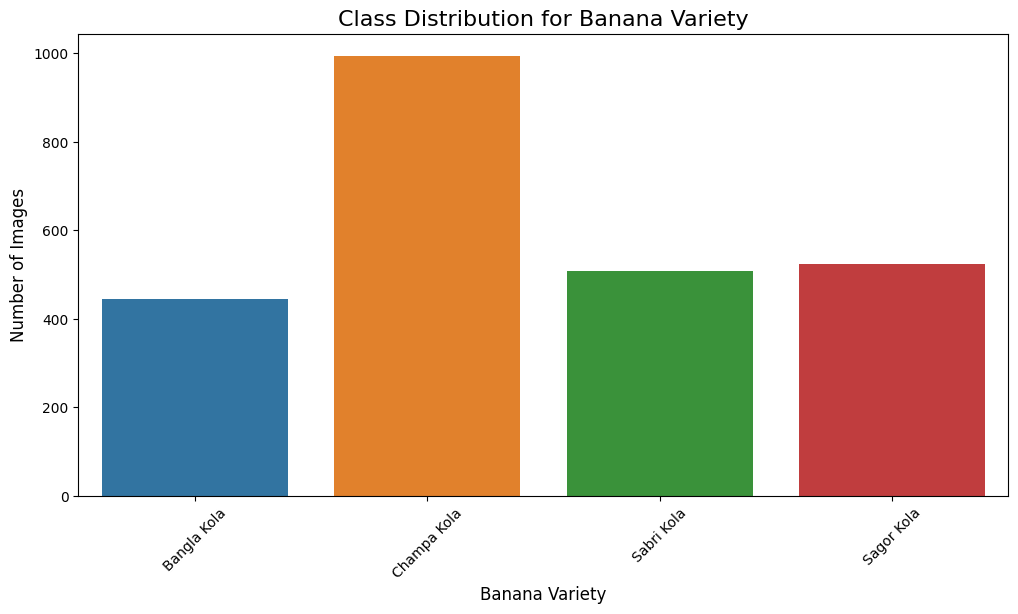


--- Visualizing Sample Images ---


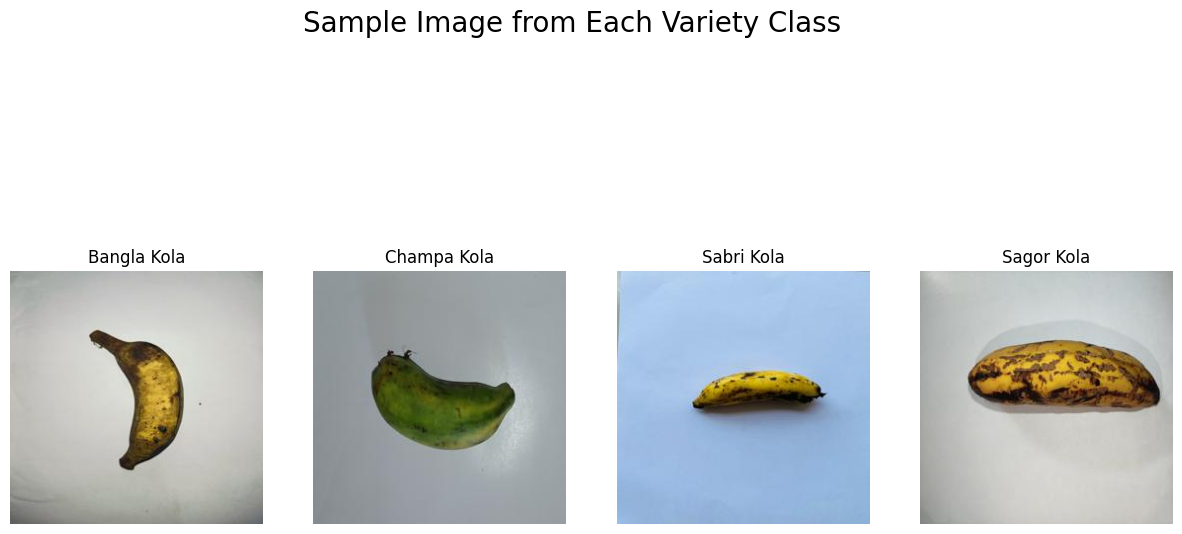

In [ ]:
# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# --- Hyperparameters ---
DATA_DIR_VARIETY = '/kaggle/input/bananaimageset/BananaImageBD A Comprehensive Image Dataset of Common Banana Varieties with Different Ripeness Stages in Bangladesh/Banana Classification Dataset/Banana Classification Dataset'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

# --- Load Class Names & Calculate Split Sizes ---
class_names_variety = sorted(os.listdir(DATA_DIR_VARIETY))
NUM_CLASSES_VARIETY = len(class_names_variety)
print(f"Variety Classes found ({NUM_CLASSES_VARIETY}): {class_names_variety}")

temp_dataset = datasets.ImageFolder(DATA_DIR_VARIETY)
train_size_v = int(0.7 * len(temp_dataset))
val_size_v = int(0.15 * len(temp_dataset))
test_size_v = len(temp_dataset) - train_size_v - val_size_v
print(f"Dataset split sizes: Train={train_size_v}, Validation={val_size_v}, Test={test_size_v}")
del temp_dataset

# --- Visualization 1: Class Distribution ---
print("\n--- Visualizing Class Distribution ---")
class_counts_variety = {cls: len(os.listdir(os.path.join(DATA_DIR_VARIETY, cls))) for cls in class_names_variety}
plt.figure(figsize=(12, 6));
sns.barplot(x=list(class_counts_variety.keys()), y=list(class_counts_variety.values()))
plt.title('Class Distribution for Banana Variety', fontsize=16)
plt.xlabel('Banana Variety', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45); plt.show()

# --- Visualization 2: Sample Images from Each Category ---
print("\n--- Visualizing Sample Images ---")
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names_variety):
    ax = plt.subplot(1, NUM_CLASSES_VARIETY, i + 1)
    img_path = os.path.join(DATA_DIR_VARIETY, class_name, os.listdir(os.path.join(DATA_DIR_VARIETY, class_name))[0])
    plt.imshow(Image.open(img_path)); plt.title(class_name); plt.axis("off")
plt.suptitle('Sample Image from Each Variety Class', fontsize=20); plt.show()

# --- Define ALL Transformations ---
# For baseline model to demonstrate overfitting
no_aug_transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# For final models to prevent overfitting
train_transforms = transforms.Compose([transforms.TrivialAugmentWide(), transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_test_transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Creating A Baseline CNN Model

### Baseline Model Design

In [ ]:
# --- Baseline Model Design ---
class BANANA_CLASS_CNN_Simple(nn.Module):
    def __init__(self, num_classes):
        super(BANANA_CLASS_CNN_Simple, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(32, num_classes), nn.Softmax(dim=1))
    def forward(self, x): return self.classifier(self.features(x))

# --- DataLoaders without Augmentation ---
full_dataset_noaug_v = datasets.ImageFolder(DATA_DIR_VARIETY, transform=no_aug_transforms)
train_ds_noaug_v, val_ds_noaug_v, _ = random_split(full_dataset_noaug_v, [train_size_v, val_size_v, test_size_v])
train_loader_noaug_v = DataLoader(train_ds_noaug_v, batch_size=BATCH_SIZE, shuffle=True)
val_loader_noaug_v = DataLoader(val_ds_noaug_v, batch_size=BATCH_SIZE, shuffle=False)


### Training the Model

In [ ]:
def train_baseline(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_acc': [], 'val_acc': []}
    print("--- Training Baseline Model (to show overfitting) ---")
    for epoch in range(epochs):
        model.train(); train_correct, train_total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device); optimizer.zero_grad(); outputs = model(inputs)
            loss = criterion(outputs, labels); loss.backward(); optimizer.step()
            _, predicted = torch.max(outputs.data, 1); train_total += labels.size(0); train_correct += (predicted == labels).sum().item()
        model.eval(); val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device)); labels = labels.to(device)
                _, predicted = torch.max(outputs.data, 1); val_total += labels.size(0); val_correct += (predicted == labels).sum().item()
        train_acc, val_acc = train_correct/train_total, val_correct/val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
    return history

baseline_model_v = BANANA_CLASS_CNN_Simple(num_classes=NUM_CLASSES_VARIETY).to(DEVICE)
baseline_history_v = train_baseline(baseline_model_v, train_loader_noaug_v, val_loader_noaug_v, epochs=15, lr=0.001, device=DEVICE)


--- Training Baseline Model (to show overfitting) ---
Epoch 1/15 | Train Acc: 0.4101 | Val Acc: 0.3973
Epoch 2/15 | Train Acc: 0.5142 | Val Acc: 0.6054
Epoch 3/15 | Train Acc: 0.5616 | Val Acc: 0.5946
Epoch 4/15 | Train Acc: 0.5784 | Val Acc: 0.6081
Epoch 5/15 | Train Acc: 0.5807 | Val Acc: 0.6081
Epoch 6/15 | Train Acc: 0.5836 | Val Acc: 0.6054
Epoch 7/15 | Train Acc: 0.5847 | Val Acc: 0.6162
Epoch 8/15 | Train Acc: 0.5865 | Val Acc: 0.6135
Epoch 9/15 | Train Acc: 0.5894 | Val Acc: 0.6162
Epoch 10/15 | Train Acc: 0.5882 | Val Acc: 0.6162
Epoch 11/15 | Train Acc: 0.5911 | Val Acc: 0.6162
Epoch 12/15 | Train Acc: 0.5905 | Val Acc: 0.6162
Epoch 13/15 | Train Acc: 0.5882 | Val Acc: 0.6135
Epoch 14/15 | Train Acc: 0.5905 | Val Acc: 0.6189
Epoch 15/15 | Train Acc: 0.5922 | Val Acc: 0.6189


### Visualizing the Overfitting problem


--- Visualizing the Overfitting Problem ---


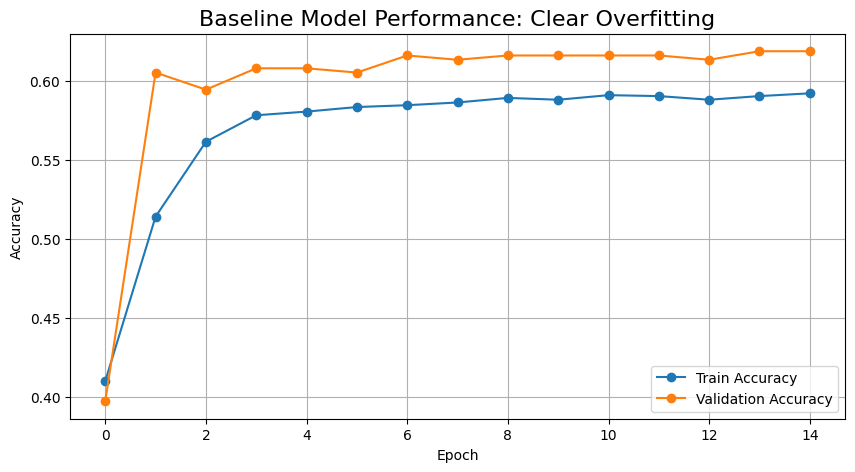

In [ ]:
print("\n--- Visualizing the Overfitting Problem ---")
plt.figure(figsize=(10, 5));
plt.plot(baseline_history_v['train_acc'], label='Train Accuracy', marker='o')
plt.plot(baseline_history_v['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Baseline Model Performance: Clear Overfitting', fontsize=16)
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True);
plt.show()

# Applying Regularization and Augmentation


--- Visualizing Sample Augmentations ---


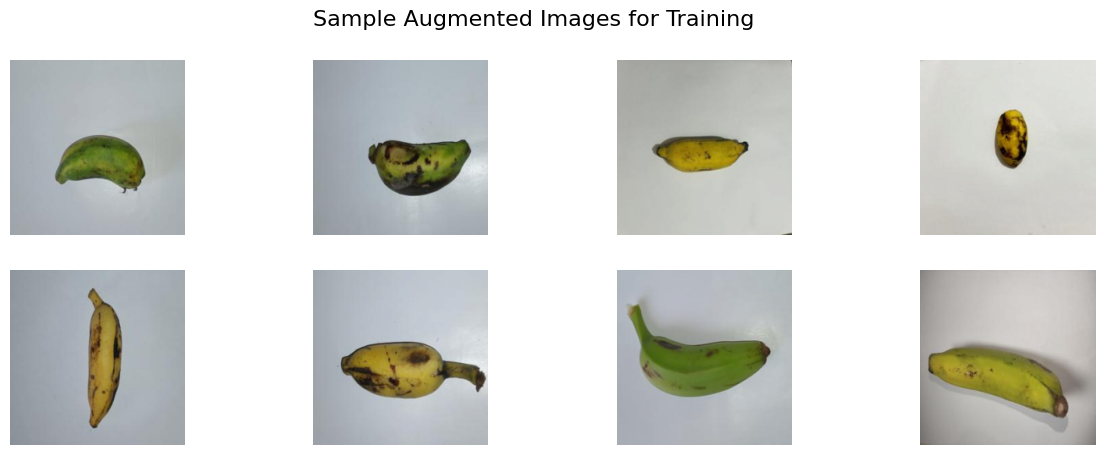

In [ ]:
# --- Final DataLoaders with Strong Augmentation ---
full_dataset_v = datasets.ImageFolder(DATA_DIR_VARIETY)
train_dataset_v, val_dataset_v, test_dataset_v = random_split(full_dataset_v, [train_size_v, val_size_v, test_size_v])
train_dataset_v.dataset.transform = train_transforms
val_dataset_v.dataset.transform = val_test_transforms
test_dataset_v.dataset.transform = val_test_transforms
train_loader_v = DataLoader(train_dataset_v, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_v = DataLoader(val_dataset_v, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_v = DataLoader(test_dataset_v, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- Visualization 3: Augmented Images ---
print("\n--- Visualizing Sample Augmentations ---")
augmented_images, _ = next(iter(train_loader_v))
plt.figure(figsize=(15, 5));
for i in range(min(8, BATCH_SIZE)):
    ax = plt.subplot(2, 4, i + 1)
    img = augmented_images[i].permute(1, 2, 0).numpy()
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    img = std * img + mean; img = np.clip(img, 0, 1)
    plt.imshow(img); plt.axis("off")
plt.suptitle('Sample Augmented Images for Training', fontsize=16); plt.show()

# Custom Model Training , Benchmarking and Comparison

## Custom Model : BANANA_CLASS_CNN

In [ ]:
class BANANA_CLASS_CNN(nn.Module):
    def __init__(self, num_classes):
        super(BANANA_CLASS_CNN, self).__init__()
        # Helper function for creating a convolutional block
        def conv_block(in_c, out_c, pool=True):
            layers = [
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),  # Regularization
                nn.ReLU(inplace=True)   # ReLU activation
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        # Feature extractor with 6 convolutional blocks
        self.features = nn.Sequential(
            conv_block(3, 32),      # Block 1: 224 -> 112
            conv_block(32, 64),     # Block 2: 112 -> 56
            conv_block(64, 128),    # Block 3: 56 -> 28
            conv_block(128, 256),   # Block 4: 28 -> 14
            conv_block(256, 512),   # Block 5: 14 -> 7
            conv_block(512, 512)    # Block 6: 7 -> 3
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5), # Regularization
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1) # Softmax for probability output
        )
    def forward(self, x): return self.classifier(self.features(x))


# Transfer Learning Models

In [ ]:
def get_transfer_model(model_name, num_classes):
    def freeze_layers(model):
        for param in model.parameters(): param.requires_grad = False
    if model_name == "resnet50": model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1); freeze_layers(model); model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg16": model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1); freeze_layers(model); model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "mobilenet_v2": model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1); freeze_layers(model); model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "efficientnet_b0": model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1); freeze_layers(model); model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "densenet121": model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1); freeze_layers(model); model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else: raise ValueError(f"Model '{model_name}' not supported.")
    return model.to(DEVICE)

## Training and Evaluation Pipeline

In [ ]:
def train_model(model, model_name, train_loader, val_loader, epochs, lr, device):
    print(f"\n--- Training {model_name} ---")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # Weight decay
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6) # LR scheduling
    scaler = GradScaler() # Mixed precision
    early_stopping_patience, min_val_loss, epochs_no_improve = 7, float('inf'), 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train(); train_loss, train_correct, train_total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device); optimizer.zero_grad()
            with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            train_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1); train_total += labels.size(0); train_correct += (predicted == labels).sum().item()

        model.eval(); val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device)); labels = labels.to(device); val_loss += criterion(outputs, labels).item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1); val_total += labels.size(0); val_correct += (predicted == labels).sum().item()

        avg_train_loss, avg_val_loss = train_loss/train_total, val_loss/val_total; avg_train_acc, avg_val_acc = train_correct/train_total, val_correct/val_total
        history['train_loss'].append(avg_train_loss); history['val_loss'].append(avg_val_loss); history['train_acc'].append(avg_train_acc); history['val_acc'].append(avg_val_acc)
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        scheduler.step()

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss; epochs_no_improve = 0; torch.save(model.state_dict(), f'{model_name}_best.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience: print(f"Early stopping at epoch {epoch+1}"); break # Early stopping
    return history

def evaluate_model(model, model_name, test_loader, class_names, device):
    model.load_state_dict(torch.load(f'{model_name}_best.pt')); model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device)); _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy()); y_true.extend(labels.cpu().numpy())
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    results = {'Accuracy': report['accuracy'], 'F1 Macro': report['macro avg']['f1-score']}
    print(f"\n--- Evaluation for {model_name} ---\n{classification_report(y_true, y_pred, target_names=class_names, zero_division=0)}")
    cm = confusion_matrix(y_true, y_pred); plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names); plt.title(f'Confusion Matrix: {model_name}'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()
    return results

## Running all experiments and results

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 157MB/s] 
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 231MB/s] 



--- Training BANANA_CLASS_CNN ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.8450 | Val Acc: 0.8378 | Train Loss: 0.9157 | Val Loss: 0.9098
Epoch 2/20 | Train Acc: 0.9190 | Val Acc: 0.9541 | Train Loss: 0.8297 | Val Loss: 0.7858
Epoch 3/20 | Train Acc: 0.9485 | Val Acc: 0.8243 | Train Loss: 0.7986 | Val Loss: 0.9178
Epoch 4/20 | Train Acc: 0.9497 | Val Acc: 0.9595 | Train Loss: 0.7963 | Val Loss: 0.7825
Epoch 5/20 | Train Acc: 0.9659 | Val Acc: 0.9703 | Train Loss: 0.7783 | Val Loss: 0.7710
Epoch 6/20 | Train Acc: 0.9728 | Val Acc: 0.9324 | Train Loss: 0.7726 | Val Loss: 0.8090
Epoch 7/20 | Train Acc: 0.9665 | Val Acc: 0.9892 | Train Loss: 0.7775 | Val Loss: 0.7578
Epoch 8/20 | Train Acc: 0.9809 | Val Acc: 0.9811 | Train Loss: 0.7634 | Val Loss: 0.7605
Epoch 9/20 | Train Acc: 0.9855 | Val Acc: 0.9946 | Train Loss: 0.7591 | Val Loss: 0.7507
Epoch 10/20 | Train Acc: 0.9913 | Val Acc: 0.9946 | Train Loss: 0.7558 | Val Loss: 0.7497
Epoch 11/20 | Train Acc: 0.9543 | Val Acc: 0.9622 | Train Loss: 0.7878 | Val Loss: 0.7798
Epoch 12/20 | Train

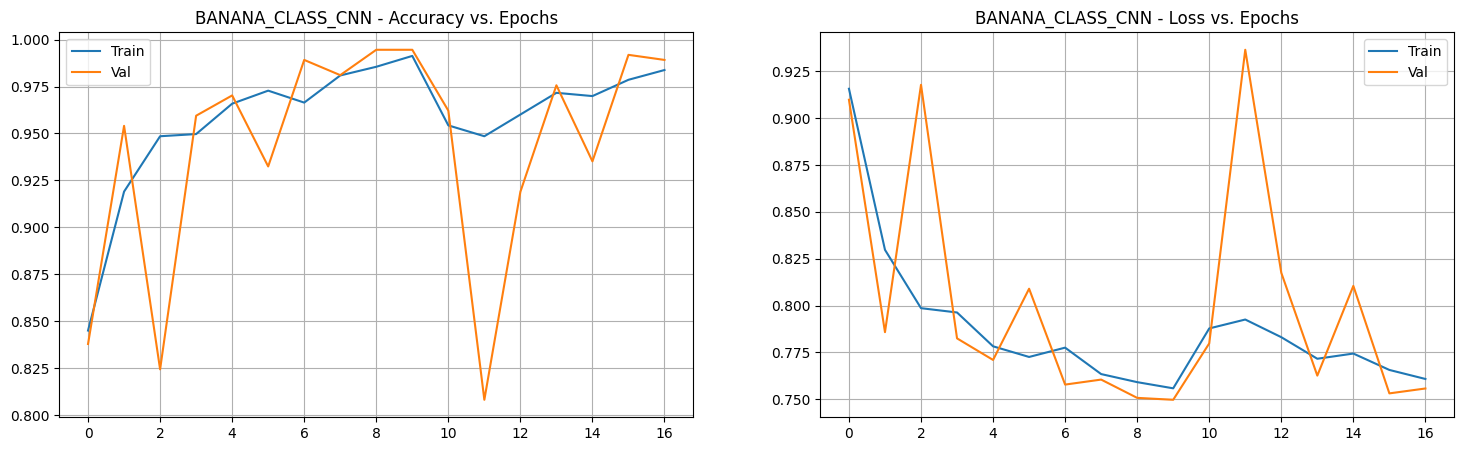


--- Evaluation for BANANA_CLASS_CNN ---
              precision    recall  f1-score   support

 Bangla Kola       1.00      0.94      0.97        65
 Champa Kola       0.99      1.00      1.00       144
  Sabri Kola       1.00      0.99      0.99        85
  Sagor Kola       0.94      0.99      0.96        78

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



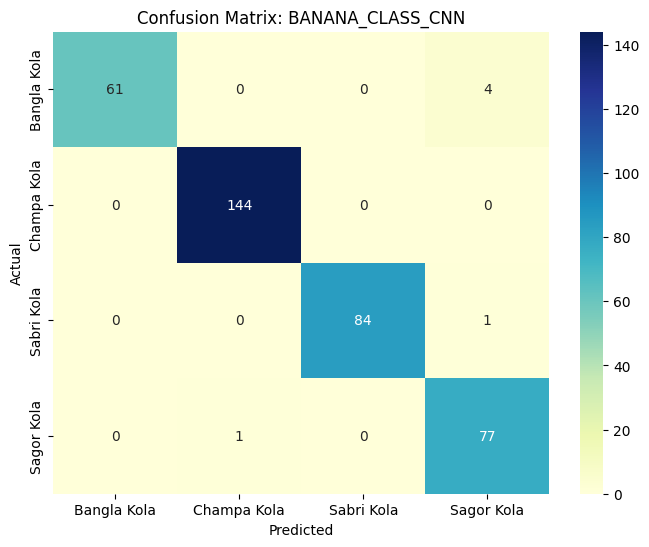


--- Training resnet50 ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.7692 | Val Acc: 0.9541 | Train Loss: 0.6970 | Val Loss: 0.3057
Epoch 2/20 | Train Acc: 0.9398 | Val Acc: 0.9811 | Train Loss: 0.2795 | Val Loss: 0.2012
Epoch 3/20 | Train Acc: 0.9479 | Val Acc: 0.9811 | Train Loss: 0.2271 | Val Loss: 0.1425
Epoch 4/20 | Train Acc: 0.9479 | Val Acc: 0.9757 | Train Loss: 0.1882 | Val Loss: 0.1384
Epoch 5/20 | Train Acc: 0.9641 | Val Acc: 0.9919 | Train Loss: 0.1582 | Val Loss: 0.1079
Epoch 6/20 | Train Acc: 0.9630 | Val Acc: 0.9838 | Train Loss: 0.1589 | Val Loss: 0.1071
Epoch 7/20 | Train Acc: 0.9705 | Val Acc: 0.9892 | Train Loss: 0.1365 | Val Loss: 0.0949
Epoch 8/20 | Train Acc: 0.9769 | Val Acc: 0.9865 | Train Loss: 0.1239 | Val Loss: 0.0958
Epoch 9/20 | Train Acc: 0.9757 | Val Acc: 0.9838 | Train Loss: 0.1137 | Val Loss: 0.0966
Epoch 10/20 | Train Acc: 0.9792 | Val Acc: 0.9811 | Train Loss: 0.1122 | Val Loss: 0.0978
Epoch 11/20 | Train Acc: 0.9676 | Val Acc: 0.9865 | Train Loss: 0.1370 | Val Loss: 0.0893
Epoch 12/20 | Train

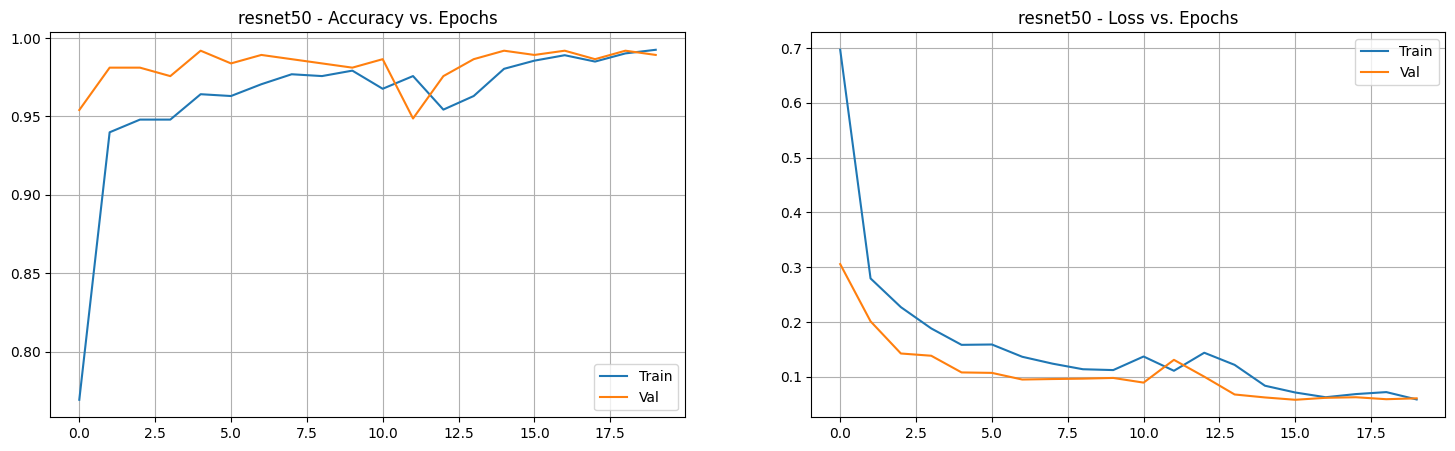


--- Evaluation for resnet50 ---
              precision    recall  f1-score   support

 Bangla Kola       0.98      0.95      0.97        65
 Champa Kola       0.99      1.00      1.00       144
  Sabri Kola       0.99      0.99      0.99        85
  Sagor Kola       0.97      0.99      0.98        78

    accuracy                           0.99       372
   macro avg       0.99      0.98      0.98       372
weighted avg       0.99      0.99      0.99       372



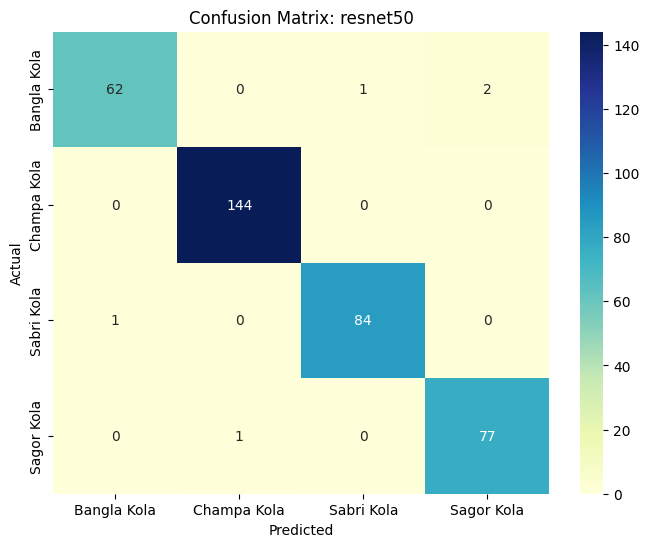


--- Training mobilenet_v2 ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.7999 | Val Acc: 0.9568 | Train Loss: 0.6421 | Val Loss: 0.2502
Epoch 2/20 | Train Acc: 0.9520 | Val Acc: 0.9784 | Train Loss: 0.2401 | Val Loss: 0.1427
Epoch 3/20 | Train Acc: 0.9595 | Val Acc: 0.9811 | Train Loss: 0.1740 | Val Loss: 0.1143
Epoch 4/20 | Train Acc: 0.9688 | Val Acc: 0.9811 | Train Loss: 0.1409 | Val Loss: 0.0904
Epoch 5/20 | Train Acc: 0.9717 | Val Acc: 0.9838 | Train Loss: 0.1240 | Val Loss: 0.0844
Epoch 6/20 | Train Acc: 0.9740 | Val Acc: 0.9865 | Train Loss: 0.1153 | Val Loss: 0.0810
Epoch 7/20 | Train Acc: 0.9774 | Val Acc: 0.9757 | Train Loss: 0.1016 | Val Loss: 0.0768
Epoch 8/20 | Train Acc: 0.9798 | Val Acc: 0.9838 | Train Loss: 0.0939 | Val Loss: 0.0761
Epoch 9/20 | Train Acc: 0.9809 | Val Acc: 0.9865 | Train Loss: 0.0900 | Val Loss: 0.0717
Epoch 10/20 | Train Acc: 0.9879 | Val Acc: 0.9838 | Train Loss: 0.0821 | Val Loss: 0.0711
Epoch 11/20 | Train Acc: 0.9803 | Val Acc: 0.9811 | Train Loss: 0.0918 | Val Loss: 0.0665
Epoch 12/20 | Train

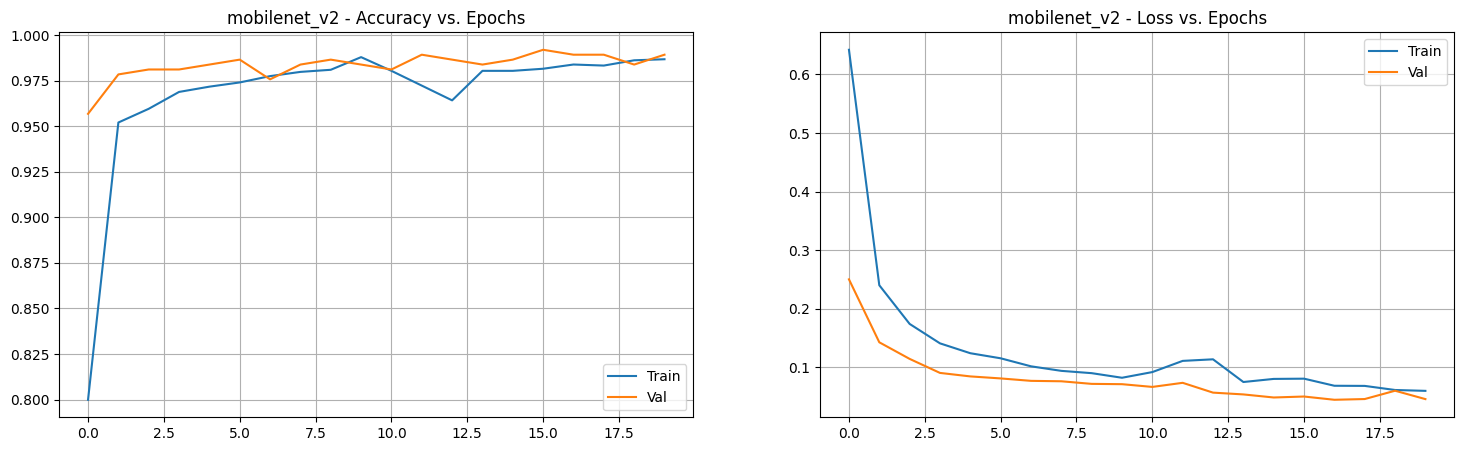


--- Evaluation for mobilenet_v2 ---
              precision    recall  f1-score   support

 Bangla Kola       0.98      0.97      0.98        65
 Champa Kola       1.00      1.00      1.00       144
  Sabri Kola       1.00      0.99      0.99        85
  Sagor Kola       0.97      1.00      0.99        78

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



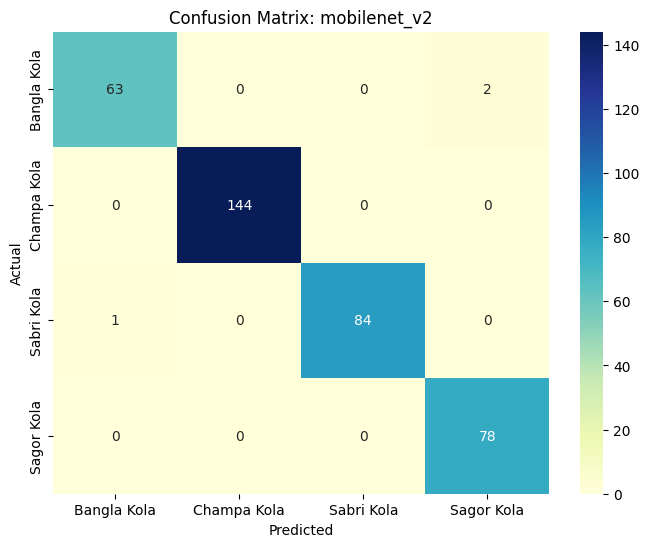


--- Training efficientnet_b0 ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.7571 | Val Acc: 0.9568 | Train Loss: 0.7480 | Val Loss: 0.3484
Epoch 2/20 | Train Acc: 0.9300 | Val Acc: 0.9757 | Train Loss: 0.3365 | Val Loss: 0.2009
Epoch 3/20 | Train Acc: 0.9566 | Val Acc: 0.9838 | Train Loss: 0.2276 | Val Loss: 0.1469
Epoch 4/20 | Train Acc: 0.9659 | Val Acc: 0.9973 | Train Loss: 0.1899 | Val Loss: 0.1209
Epoch 5/20 | Train Acc: 0.9659 | Val Acc: 0.9946 | Train Loss: 0.1625 | Val Loss: 0.1138
Epoch 6/20 | Train Acc: 0.9740 | Val Acc: 0.9919 | Train Loss: 0.1526 | Val Loss: 0.0993
Epoch 7/20 | Train Acc: 0.9722 | Val Acc: 0.9946 | Train Loss: 0.1543 | Val Loss: 0.1037
Epoch 8/20 | Train Acc: 0.9774 | Val Acc: 0.9946 | Train Loss: 0.1299 | Val Loss: 0.0845
Epoch 9/20 | Train Acc: 0.9803 | Val Acc: 0.9892 | Train Loss: 0.1228 | Val Loss: 0.1033
Epoch 10/20 | Train Acc: 0.9809 | Val Acc: 0.9919 | Train Loss: 0.1316 | Val Loss: 0.0927
Epoch 11/20 | Train Acc: 0.9676 | Val Acc: 0.9973 | Train Loss: 0.1400 | Val Loss: 0.0809
Epoch 12/20 | Train

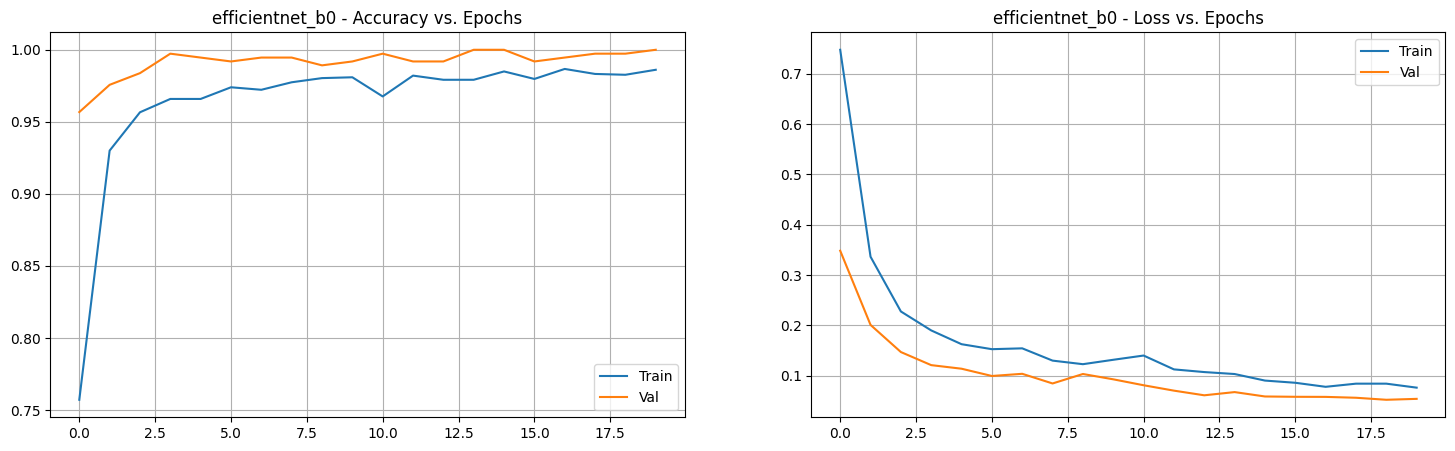


--- Evaluation for efficientnet_b0 ---
              precision    recall  f1-score   support

 Bangla Kola       0.97      0.97      0.97        65
 Champa Kola       1.00      0.98      0.99       144
  Sabri Kola       0.99      0.98      0.98        85
  Sagor Kola       0.95      1.00      0.97        78

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



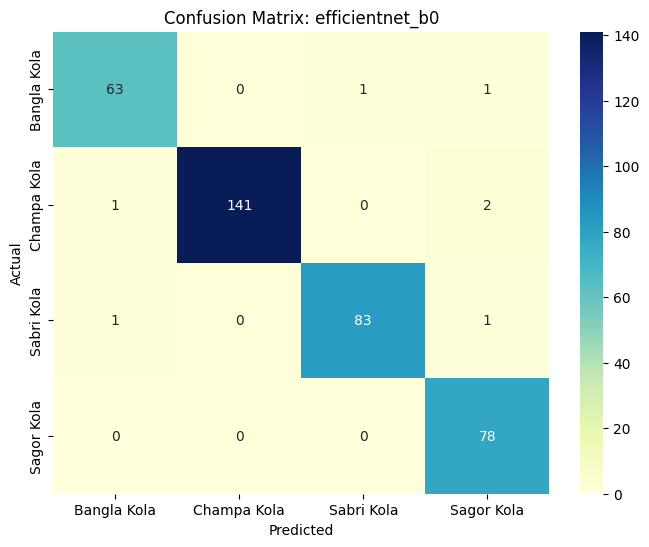


--- Training densenet121 ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.8086 | Val Acc: 0.9757 | Train Loss: 0.7042 | Val Loss: 0.3651
Epoch 2/20 | Train Acc: 0.9427 | Val Acc: 0.9730 | Train Loss: 0.2981 | Val Loss: 0.1750
Epoch 3/20 | Train Acc: 0.9566 | Val Acc: 0.9892 | Train Loss: 0.2163 | Val Loss: 0.1426
Epoch 4/20 | Train Acc: 0.9757 | Val Acc: 0.9919 | Train Loss: 0.1595 | Val Loss: 0.1458
Epoch 5/20 | Train Acc: 0.9665 | Val Acc: 0.9919 | Train Loss: 0.1602 | Val Loss: 0.1068
Epoch 6/20 | Train Acc: 0.9734 | Val Acc: 0.9865 | Train Loss: 0.1301 | Val Loss: 0.1041
Epoch 7/20 | Train Acc: 0.9838 | Val Acc: 0.9946 | Train Loss: 0.1126 | Val Loss: 0.0961
Epoch 8/20 | Train Acc: 0.9838 | Val Acc: 0.9919 | Train Loss: 0.1150 | Val Loss: 0.0929
Epoch 9/20 | Train Acc: 0.9855 | Val Acc: 0.9892 | Train Loss: 0.1073 | Val Loss: 0.1021
Epoch 10/20 | Train Acc: 0.9867 | Val Acc: 0.9919 | Train Loss: 0.1060 | Val Loss: 0.1056
Epoch 11/20 | Train Acc: 0.9821 | Val Acc: 0.9919 | Train Loss: 0.1117 | Val Loss: 0.0776
Epoch 12/20 | Train

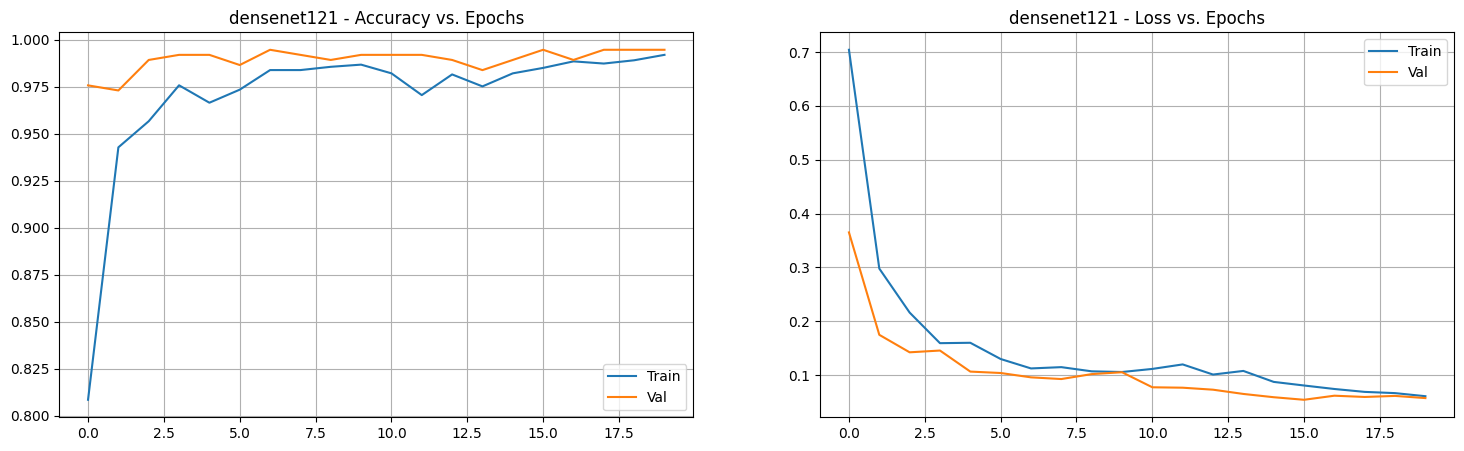


--- Evaluation for densenet121 ---
              precision    recall  f1-score   support

 Bangla Kola       0.98      0.94      0.96        65
 Champa Kola       0.99      1.00      1.00       144
  Sabri Kola       0.98      0.99      0.98        85
  Sagor Kola       0.97      0.99      0.98        78

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



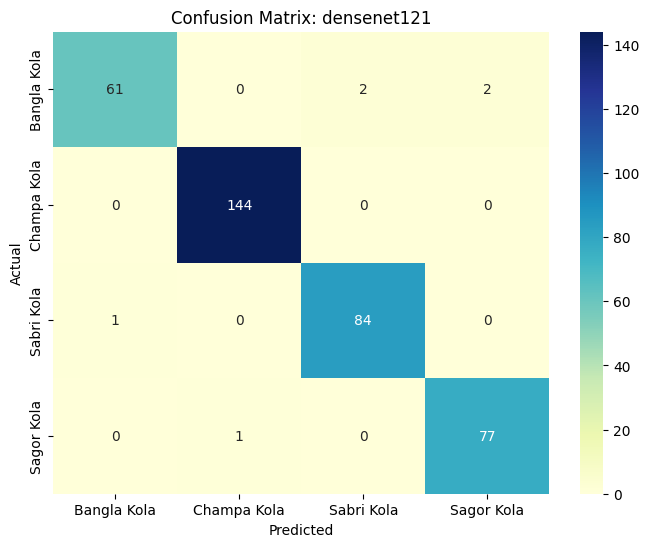


--- Training vgg16 ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.8242 | Val Acc: 0.9568 | Train Loss: 0.4740 | Val Loss: 0.1610
Epoch 2/20 | Train Acc: 0.9497 | Val Acc: 0.9486 | Train Loss: 0.1753 | Val Loss: 0.1547
Epoch 3/20 | Train Acc: 0.9543 | Val Acc: 0.9703 | Train Loss: 0.1440 | Val Loss: 0.0961
Epoch 4/20 | Train Acc: 0.9566 | Val Acc: 0.9784 | Train Loss: 0.1202 | Val Loss: 0.0832
Epoch 5/20 | Train Acc: 0.9659 | Val Acc: 0.9649 | Train Loss: 0.1025 | Val Loss: 0.0905
Epoch 6/20 | Train Acc: 0.9722 | Val Acc: 0.9865 | Train Loss: 0.0962 | Val Loss: 0.0704
Epoch 7/20 | Train Acc: 0.9746 | Val Acc: 0.9757 | Train Loss: 0.0921 | Val Loss: 0.0722
Epoch 8/20 | Train Acc: 0.9688 | Val Acc: 0.9865 | Train Loss: 0.0929 | Val Loss: 0.0679
Epoch 9/20 | Train Acc: 0.9774 | Val Acc: 0.9784 | Train Loss: 0.0791 | Val Loss: 0.0720
Epoch 10/20 | Train Acc: 0.9711 | Val Acc: 0.9784 | Train Loss: 0.0867 | Val Loss: 0.0717
Epoch 11/20 | Train Acc: 0.9670 | Val Acc: 0.9919 | Train Loss: 0.0950 | Val Loss: 0.0571
Epoch 12/20 | Train

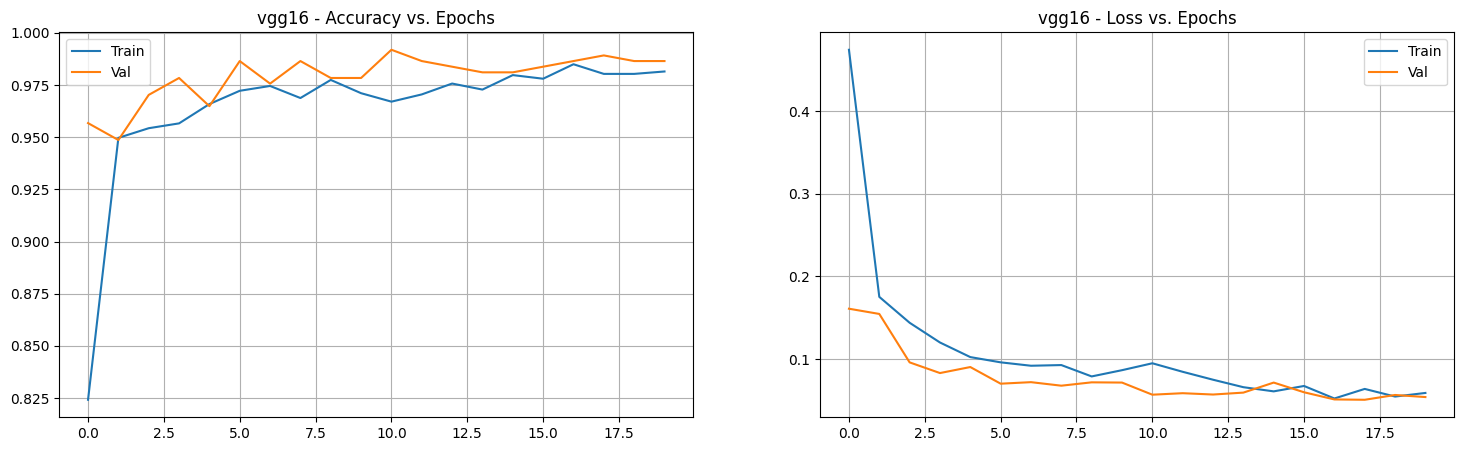


--- Evaluation for vgg16 ---
              precision    recall  f1-score   support

 Bangla Kola       0.95      0.95      0.95        65
 Champa Kola       0.99      0.99      0.99       144
  Sabri Kola       0.99      0.98      0.98        85
  Sagor Kola       0.96      0.97      0.97        78

    accuracy                           0.98       372
   macro avg       0.97      0.97      0.97       372
weighted avg       0.98      0.98      0.98       372



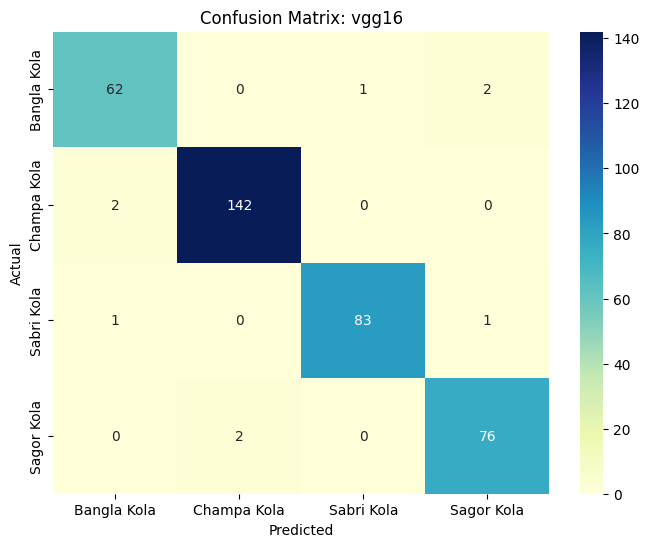



--- FINAL MODEL COMPARISON (BANANA VARIETY) ---


,Accuracy,F1 Macro
Model,,
mobilenet_v2,0.9919,0.9895
resnet50,0.9866,0.9836
BANANA_CLASS_CNN,0.9839,0.9803
densenet121,0.9839,0.9801
efficientnet_b0,0.9812,0.9790
vgg16,0.9758,0.9726


In [ ]:
# --- Run All Experiments ---
models_to_train_v = {
    "BANANA_CLASS_CNN": BANANA_CLASS_CNN(num_classes=NUM_CLASSES_VARIETY).to(DEVICE),
    "resnet50": get_transfer_model("resnet50", num_classes=NUM_CLASSES_VARIETY),
    "mobilenet_v2": get_transfer_model("mobilenet_v2", num_classes=NUM_CLASSES_VARIETY),
    "efficientnet_b0": get_transfer_model("efficientnet_b0", num_classes=NUM_CLASSES_VARIETY),
    "densenet121": get_transfer_model("densenet121", num_classes=NUM_CLASSES_VARIETY),
    "vgg16": get_transfer_model("vgg16", num_classes=NUM_CLASSES_VARIETY)}

all_results_v = []
for name, model in models_to_train_v.items():
    history = train_model(model, name, train_loader_v, val_loader_v, EPOCHS, LEARNING_RATE, DEVICE)
    plt.figure(figsize=(18, 5)); plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.title(f'{name} - Accuracy vs. Epochs'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.title(f'{name} - Loss vs. Epochs'); plt.legend(); plt.grid(True); plt.show()
    eval_results = evaluate_model(model, name, test_loader_v, class_names_variety, DEVICE)
    eval_results['Model'] = name
    all_results_v.append(eval_results)

# --- Final Comparison Table ---
print("\n\n--- FINAL MODEL COMPARISON (BANANA VARIETY) ---")
results_df_v = pd.DataFrame(all_results_v).set_index('Model').sort_values(by='Accuracy', ascending=False)
display(results_df_v.style.background_gradient(cmap='viridis').format("{:.4f}"))

# Part B: Banana Ripeness Detection

# Setup for ripeness Detection



############################################################
### PART B: BANANA RIPENESS DETECTION ###
############################################################
Ripeness Classes found (4): ['Green', 'Overripe', 'Ripe', 'Semi-ripe']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


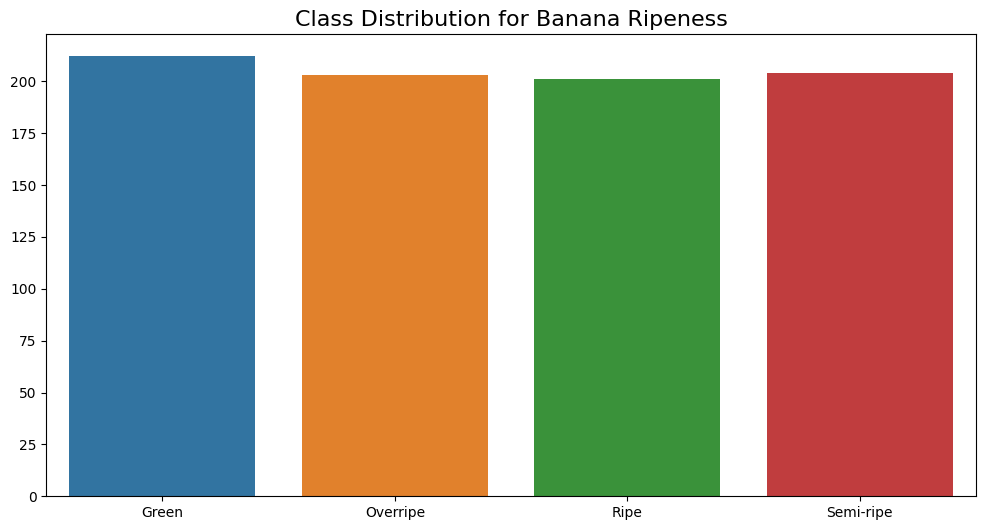

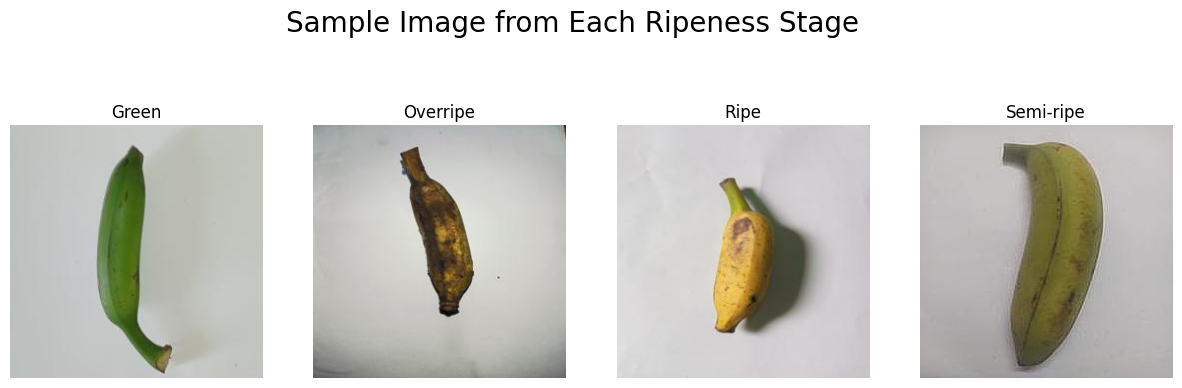

In [ ]:
print("\n\n" + "#"*60 + "\n### PART B: BANANA RIPENESS DETECTION ###\n" + "#"*60)

# --- Path and Class Names ---
DATA_DIR_RIPENESS = '/kaggle/input/bananaimageset/BananaImageBD A Comprehensive Image Dataset of Common Banana Varieties with Different Ripeness Stages in Bangladesh/Banana Ripeness Detection Dataset/Banana Ripeness Detection Dataset'
class_names_ripeness = sorted(os.listdir(DATA_DIR_RIPENESS))
NUM_CLASSES_RIPENESS = len(class_names_ripeness)
print(f"Ripeness Classes found ({NUM_CLASSES_RIPENESS}): {class_names_ripeness}")
temp_dataset_r = datasets.ImageFolder(DATA_DIR_RIPENESS); train_size_r = int(0.7*len(temp_dataset_r)); val_size_r = int(0.15*len(temp_dataset_r)); test_size_r = len(temp_dataset_r) - train_size_r - val_size_r; del temp_dataset_r

# --- Data Visualizations for Ripeness ---
class_counts_ripeness = {cls: len(os.listdir(os.path.join(DATA_DIR_RIPENESS, cls))) for cls in class_names_ripeness}
plt.figure(figsize=(12, 6)); sns.barplot(x=list(class_counts_ripeness.keys()), y=list(class_counts_ripeness.values())); plt.title('Class Distribution for Banana Ripeness', fontsize=16); plt.show()
plt.figure(figsize=(15, 5));
for i, class_name in enumerate(class_names_ripeness):
    ax = plt.subplot(1, NUM_CLASSES_RIPENESS, i+1); img_path = os.path.join(DATA_DIR_RIPENESS, class_name, os.listdir(os.path.join(DATA_DIR_RIPENESS, class_name))[0])
    plt.imshow(Image.open(img_path)); plt.title(class_name); plt.axis("off")
plt.suptitle('Sample Image from Each Ripeness Stage', fontsize=20); plt.show()

# --- DataLoaders ---
full_dataset_r = datasets.ImageFolder(DATA_DIR_RIPENESS); train_dataset_r, val_dataset_r, test_dataset_r = random_split(full_dataset_r, [train_size_r, val_size_r, test_size_r])
train_dataset_r.dataset.transform = train_transforms; val_dataset_r.dataset.transform = val_test_transforms; test_dataset_r.dataset.transform = val_test_transforms
train_loader_r = DataLoader(train_dataset_r, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_r = DataLoader(val_dataset_r, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_r = DataLoader(test_dataset_r, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


## Custom CNN Model and Experiment

In [ ]:
class BANANA_RIPE_CNN(nn.Module):
    def __init__(self, num_classes):
        super(BANANA_RIPE_CNN, self).__init__()
        def conv_block(in_c, out_c, pool=True, dropout_p=0.0):
            layers = [nn.Conv2d(in_c, out_c, 3, 1), nn.BatchNorm2d(out_c), nn.ReLU()]
            if pool: layers.append(nn.MaxPool2d(2))
            if dropout_p > 0: layers.append(nn.Dropout(dropout_p))
            return nn.Sequential(*layers)
        self.features = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128, dropout_p=0.2),
            conv_block(128, 256, dropout_p=0.3),
            conv_block(256, 512, dropout_p=0.4),
            conv_block(512, 512, pool=False))
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(512, num_classes), nn.Softmax(dim=1))
    def forward(self, x): return self.classifier(self.features(x))


## Training and Final Result


--- Training BANANA_RIPE_CNN ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.8014 | Val Acc: 0.3659 | Train Loss: 0.9638 | Val Loss: 1.2841
Epoch 2/20 | Train Acc: 0.9129 | Val Acc: 0.6748 | Train Loss: 0.8396 | Val Loss: 1.0385
Epoch 3/20 | Train Acc: 0.9286 | Val Acc: 0.8943 | Train Loss: 0.8241 | Val Loss: 0.8493
Epoch 4/20 | Train Acc: 0.9286 | Val Acc: 0.9431 | Train Loss: 0.8225 | Val Loss: 0.8142
Epoch 5/20 | Train Acc: 0.9495 | Val Acc: 0.9512 | Train Loss: 0.8043 | Val Loss: 0.7939
Epoch 6/20 | Train Acc: 0.9530 | Val Acc: 0.9512 | Train Loss: 0.7979 | Val Loss: 0.7875
Epoch 7/20 | Train Acc: 0.9547 | Val Acc: 0.9675 | Train Loss: 0.7933 | Val Loss: 0.7802
Epoch 8/20 | Train Acc: 0.9634 | Val Acc: 0.9512 | Train Loss: 0.7846 | Val Loss: 0.7911
Epoch 9/20 | Train Acc: 0.9599 | Val Acc: 0.9675 | Train Loss: 0.7885 | Val Loss: 0.7841
Epoch 10/20 | Train Acc: 0.9582 | Val Acc: 0.9675 | Train Loss: 0.7878 | Val Loss: 0.7820
Epoch 11/20 | Train Acc: 0.9286 | Val Acc: 0.6179 | Train Loss: 0.8143 | Val Loss: 1.1228
Epoch 12/20 | Train

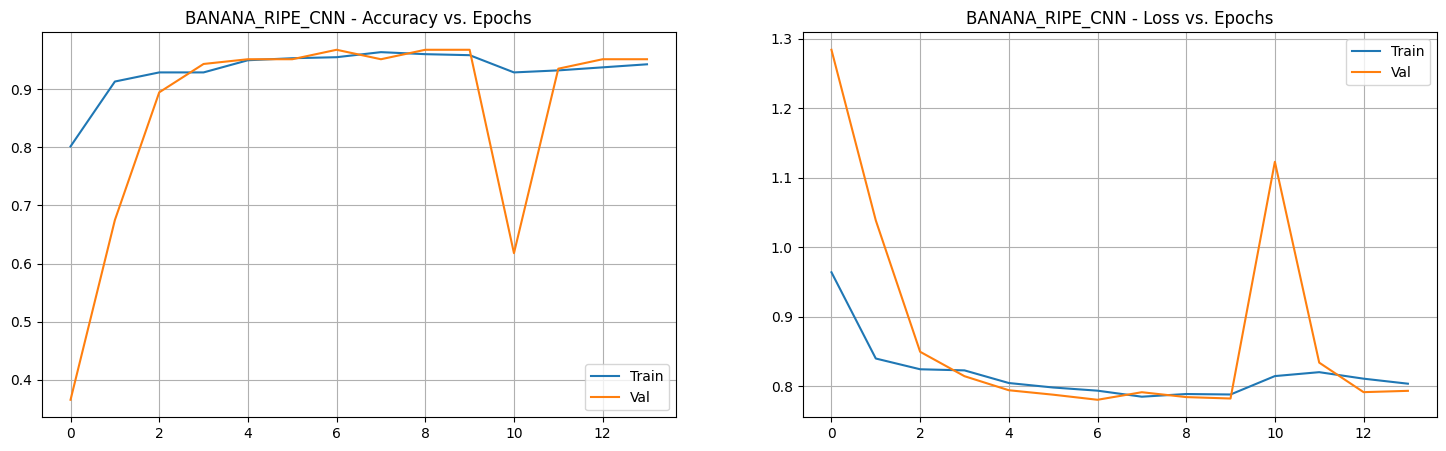


--- Evaluation for BANANA_RIPE_CNN ---
              precision    recall  f1-score   support

       Green       1.00      0.97      0.98        30
    Overripe       1.00      0.94      0.97        31
        Ripe       0.94      0.83      0.88        35
   Semi-ripe       0.79      1.00      0.89        27

    accuracy                           0.93       123
   macro avg       0.93      0.93      0.93       123
weighted avg       0.94      0.93      0.93       123



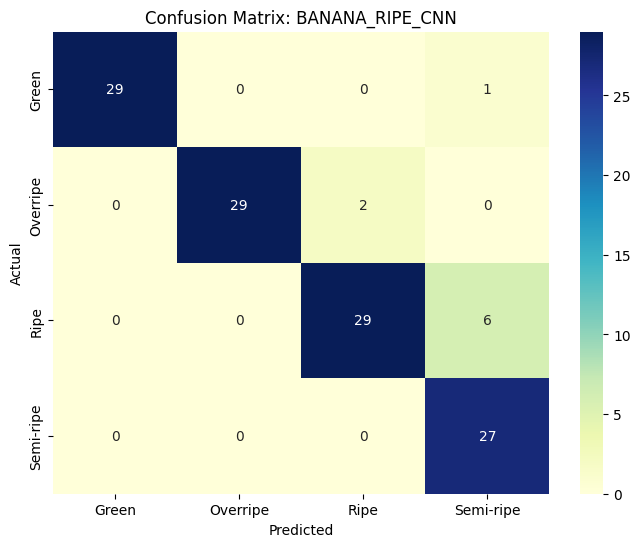


--- Training resnet50_r ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.5854 | Val Acc: 0.8699 | Train Loss: 1.0896 | Val Loss: 0.7112
Epoch 2/20 | Train Acc: 0.8990 | Val Acc: 0.9187 | Train Loss: 0.6043 | Val Loss: 0.4544
Epoch 3/20 | Train Acc: 0.8833 | Val Acc: 0.9431 | Train Loss: 0.4624 | Val Loss: 0.3432
Epoch 4/20 | Train Acc: 0.9024 | Val Acc: 0.9350 | Train Loss: 0.3823 | Val Loss: 0.3319
Epoch 5/20 | Train Acc: 0.9181 | Val Acc: 0.9431 | Train Loss: 0.3382 | Val Loss: 0.2767
Epoch 6/20 | Train Acc: 0.9338 | Val Acc: 0.9268 | Train Loss: 0.3173 | Val Loss: 0.2780
Epoch 7/20 | Train Acc: 0.9216 | Val Acc: 0.9512 | Train Loss: 0.3111 | Val Loss: 0.2563
Epoch 8/20 | Train Acc: 0.9199 | Val Acc: 0.9350 | Train Loss: 0.3071 | Val Loss: 0.2535
Epoch 9/20 | Train Acc: 0.9373 | Val Acc: 0.9431 | Train Loss: 0.2821 | Val Loss: 0.2508
Epoch 10/20 | Train Acc: 0.9373 | Val Acc: 0.9431 | Train Loss: 0.2784 | Val Loss: 0.2496
Epoch 11/20 | Train Acc: 0.9164 | Val Acc: 0.9187 | Train Loss: 0.3078 | Val Loss: 0.2813
Epoch 12/20 | Train

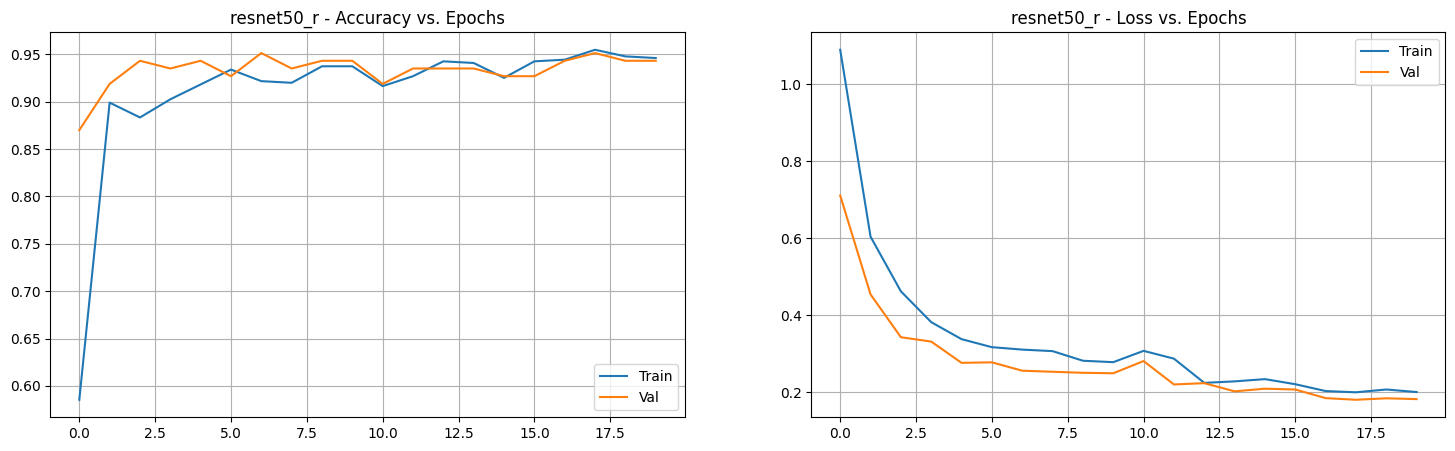


--- Evaluation for resnet50_r ---
              precision    recall  f1-score   support

       Green       0.96      0.90      0.93        30
    Overripe       1.00      0.97      0.98        31
        Ripe       0.94      0.83      0.88        35
   Semi-ripe       0.71      0.89      0.79        27

    accuracy                           0.89       123
   macro avg       0.90      0.90      0.90       123
weighted avg       0.91      0.89      0.90       123



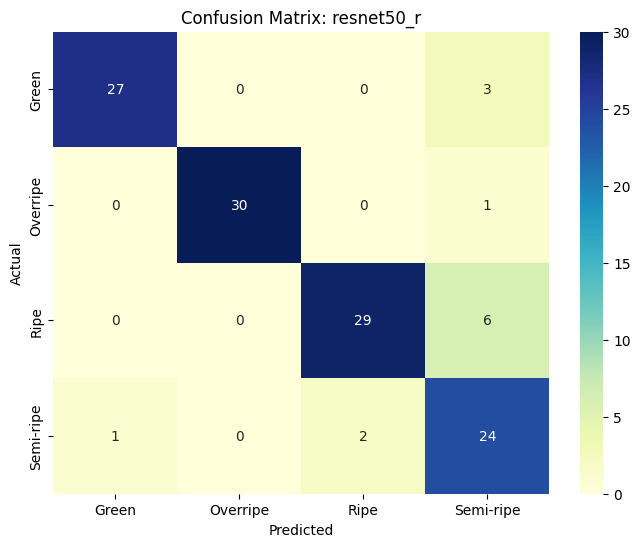


--- Training mobilenet_v2_r ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.6481 | Val Acc: 0.8943 | Train Loss: 0.9931 | Val Loss: 0.6499
Epoch 2/20 | Train Acc: 0.8624 | Val Acc: 0.8618 | Train Loss: 0.5320 | Val Loss: 0.4652
Epoch 3/20 | Train Acc: 0.9007 | Val Acc: 0.9268 | Train Loss: 0.3822 | Val Loss: 0.3535
Epoch 4/20 | Train Acc: 0.8868 | Val Acc: 0.9187 | Train Loss: 0.3750 | Val Loss: 0.3271
Epoch 5/20 | Train Acc: 0.8902 | Val Acc: 0.9024 | Train Loss: 0.3188 | Val Loss: 0.3121
Epoch 6/20 | Train Acc: 0.9077 | Val Acc: 0.9350 | Train Loss: 0.3066 | Val Loss: 0.2851
Epoch 7/20 | Train Acc: 0.9251 | Val Acc: 0.9268 | Train Loss: 0.2697 | Val Loss: 0.2737
Epoch 8/20 | Train Acc: 0.9303 | Val Acc: 0.9268 | Train Loss: 0.2677 | Val Loss: 0.2697
Epoch 9/20 | Train Acc: 0.9268 | Val Acc: 0.9268 | Train Loss: 0.2603 | Val Loss: 0.2700
Epoch 10/20 | Train Acc: 0.9530 | Val Acc: 0.9187 | Train Loss: 0.2281 | Val Loss: 0.2740
Epoch 11/20 | Train Acc: 0.9321 | Val Acc: 0.9350 | Train Loss: 0.2449 | Val Loss: 0.2442
Epoch 12/20 | Train

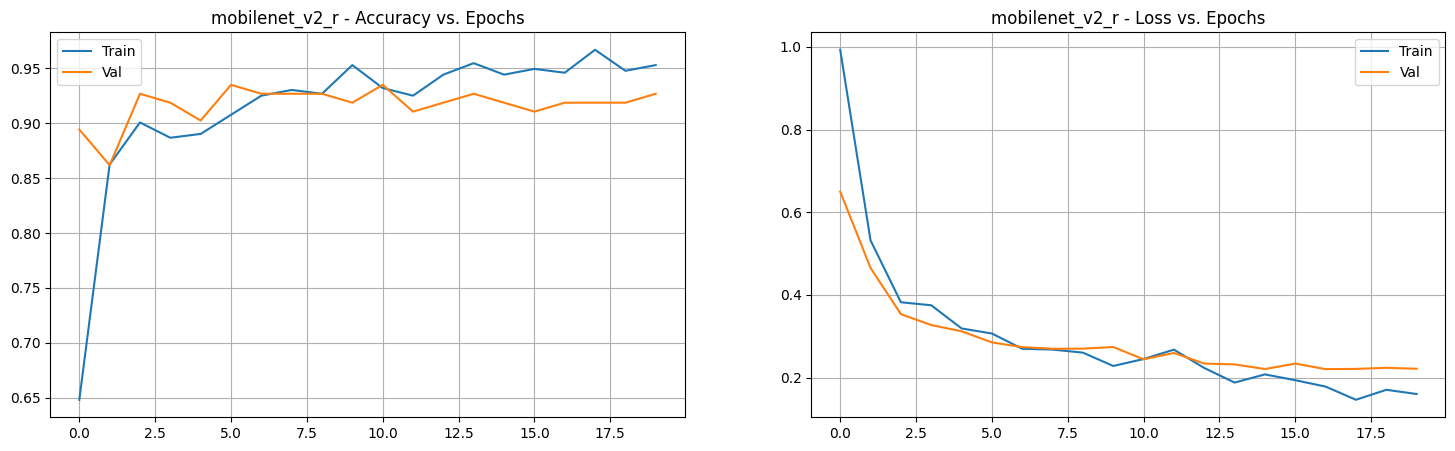


--- Evaluation for mobilenet_v2_r ---
              precision    recall  f1-score   support

       Green       1.00      0.93      0.97        30
    Overripe       0.97      0.90      0.93        31
        Ripe       0.87      0.74      0.80        35
   Semi-ripe       0.72      0.96      0.83        27

    accuracy                           0.88       123
   macro avg       0.89      0.89      0.88       123
weighted avg       0.89      0.88      0.88       123



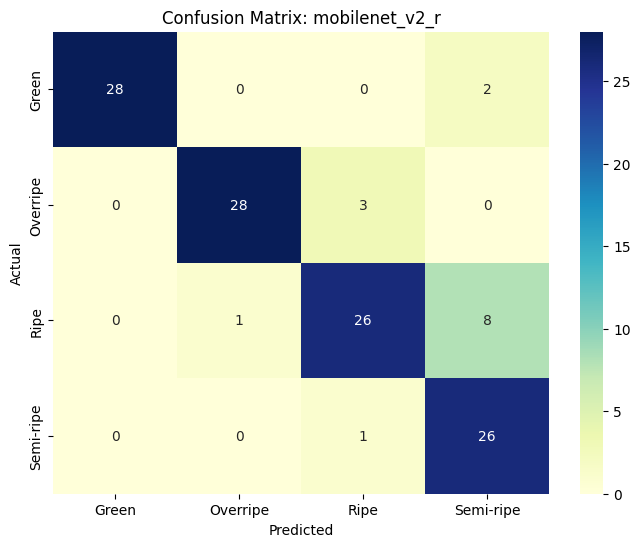


--- Training efficientnet_b0_r ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.6916 | Val Acc: 0.8537 | Train Loss: 1.0682 | Val Loss: 0.7575
Epoch 2/20 | Train Acc: 0.8885 | Val Acc: 0.8862 | Train Loss: 0.6447 | Val Loss: 0.5003
Epoch 3/20 | Train Acc: 0.8920 | Val Acc: 0.9024 | Train Loss: 0.4907 | Val Loss: 0.4095
Epoch 4/20 | Train Acc: 0.9303 | Val Acc: 0.8862 | Train Loss: 0.3963 | Val Loss: 0.3725
Epoch 5/20 | Train Acc: 0.9408 | Val Acc: 0.9024 | Train Loss: 0.3468 | Val Loss: 0.3363
Epoch 6/20 | Train Acc: 0.9286 | Val Acc: 0.8862 | Train Loss: 0.3265 | Val Loss: 0.3298
Epoch 7/20 | Train Acc: 0.9268 | Val Acc: 0.8862 | Train Loss: 0.3199 | Val Loss: 0.3239
Epoch 8/20 | Train Acc: 0.9425 | Val Acc: 0.8943 | Train Loss: 0.2945 | Val Loss: 0.3230
Epoch 9/20 | Train Acc: 0.9216 | Val Acc: 0.9024 | Train Loss: 0.3147 | Val Loss: 0.3018
Epoch 10/20 | Train Acc: 0.9321 | Val Acc: 0.8862 | Train Loss: 0.2975 | Val Loss: 0.3175
Epoch 11/20 | Train Acc: 0.9268 | Val Acc: 0.9106 | Train Loss: 0.2925 | Val Loss: 0.2942
Epoch 12/20 | Train

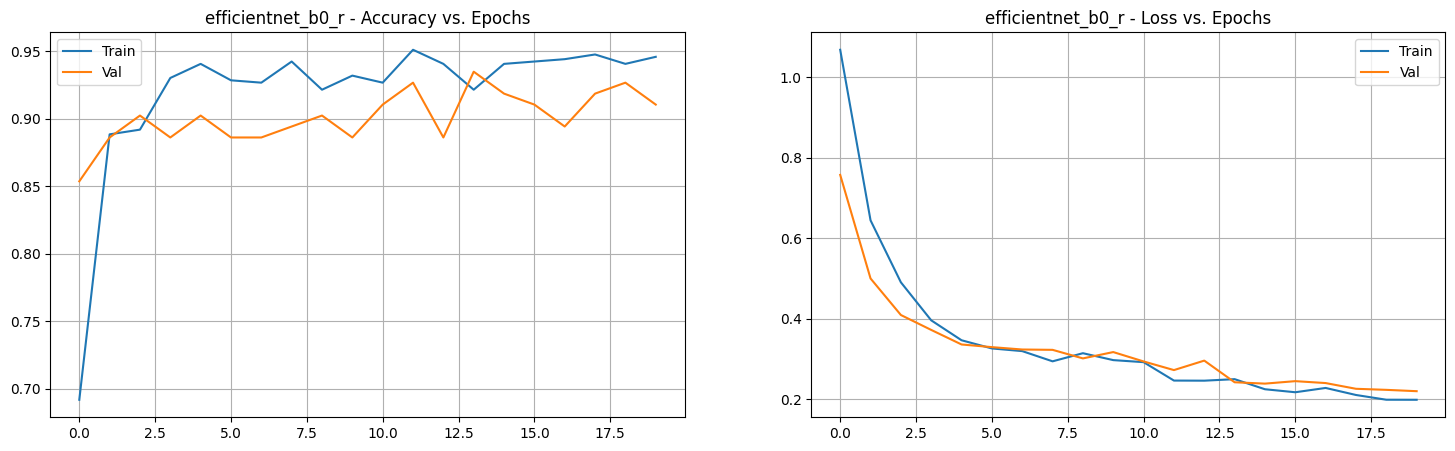


--- Evaluation for efficientnet_b0_r ---
              precision    recall  f1-score   support

       Green       0.96      0.90      0.93        30
    Overripe       0.93      0.87      0.90        31
        Ripe       0.89      0.71      0.79        35
   Semi-ripe       0.66      0.93      0.77        27

    accuracy                           0.85       123
   macro avg       0.86      0.85      0.85       123
weighted avg       0.87      0.85      0.85       123



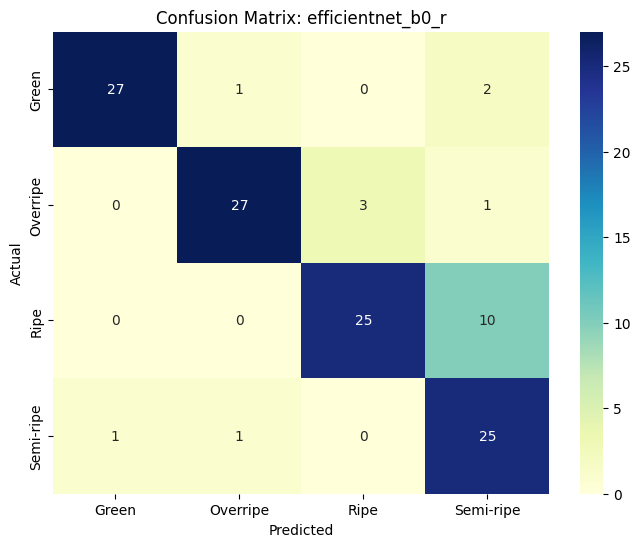


--- Training densenet121_r ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.4895 | Val Acc: 0.8049 | Train Loss: 1.2490 | Val Loss: 0.9765
Epoch 2/20 | Train Acc: 0.8328 | Val Acc: 0.9024 | Train Loss: 0.8035 | Val Loss: 0.6331
Epoch 3/20 | Train Acc: 0.8641 | Val Acc: 0.9024 | Train Loss: 0.6017 | Val Loss: 0.4775
Epoch 4/20 | Train Acc: 0.8902 | Val Acc: 0.9106 | Train Loss: 0.5012 | Val Loss: 0.4038
Epoch 5/20 | Train Acc: 0.8798 | Val Acc: 0.9350 | Train Loss: 0.4708 | Val Loss: 0.3595
Epoch 6/20 | Train Acc: 0.9181 | Val Acc: 0.9268 | Train Loss: 0.4196 | Val Loss: 0.3309
Epoch 7/20 | Train Acc: 0.9164 | Val Acc: 0.9187 | Train Loss: 0.3968 | Val Loss: 0.3238
Epoch 8/20 | Train Acc: 0.9129 | Val Acc: 0.9512 | Train Loss: 0.3771 | Val Loss: 0.3178
Epoch 9/20 | Train Acc: 0.9251 | Val Acc: 0.9350 | Train Loss: 0.3690 | Val Loss: 0.3127
Epoch 10/20 | Train Acc: 0.9390 | Val Acc: 0.9268 | Train Loss: 0.3665 | Val Loss: 0.3107
Epoch 11/20 | Train Acc: 0.9233 | Val Acc: 0.9512 | Train Loss: 0.3527 | Val Loss: 0.2834
Epoch 12/20 | Train

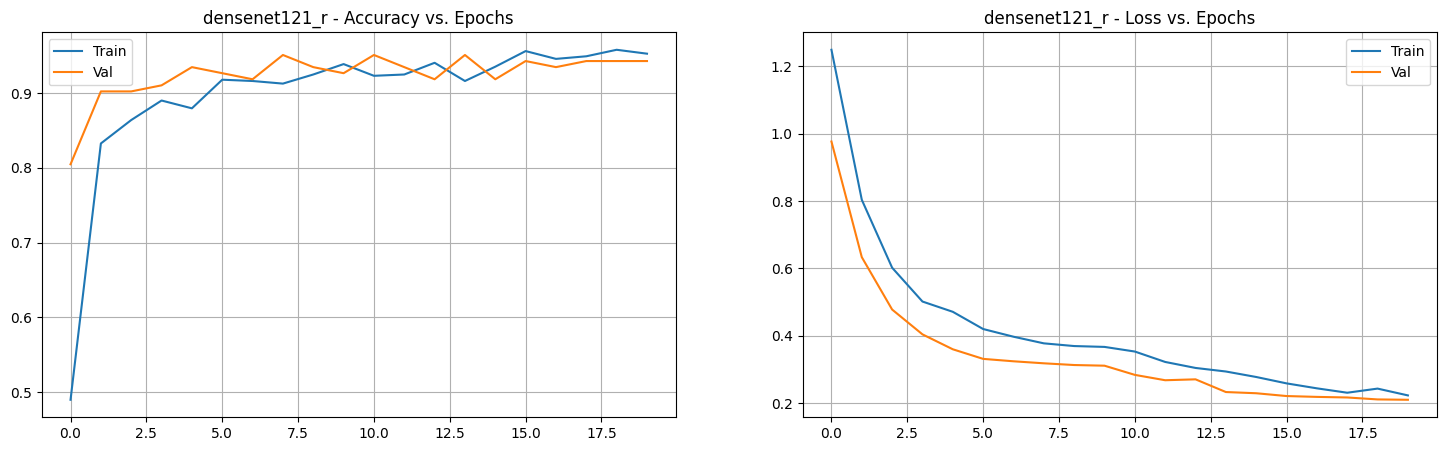


--- Evaluation for densenet121_r ---
              precision    recall  f1-score   support

       Green       0.97      0.97      0.97        30
    Overripe       0.91      0.94      0.92        31
        Ripe       0.86      0.71      0.78        35
   Semi-ripe       0.72      0.85      0.78        27

    accuracy                           0.86       123
   macro avg       0.86      0.87      0.86       123
weighted avg       0.87      0.86      0.86       123



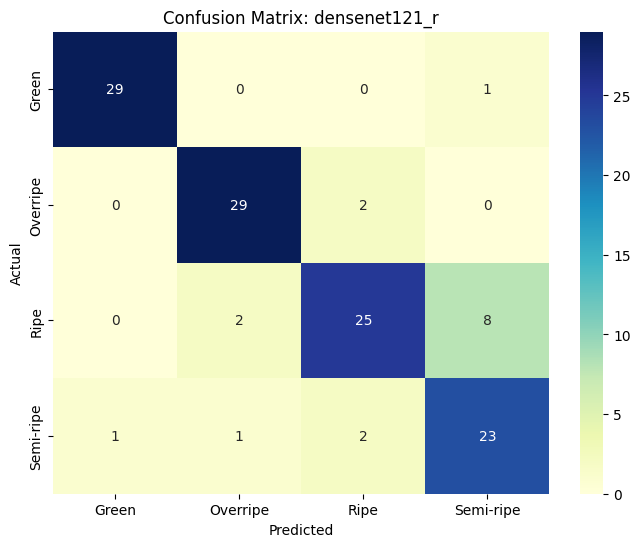


--- Training vgg16_r ---


/tmp/ipykernel_36/1634103642.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Mixed precision
/tmp/ipykernel_36/1634103642.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(inputs); loss = criterion(outputs, labels) # Mixed precision


Epoch 1/20 | Train Acc: 0.6551 | Val Acc: 0.8699 | Train Loss: 0.8045 | Val Loss: 0.3579
Epoch 2/20 | Train Acc: 0.8537 | Val Acc: 0.9024 | Train Loss: 0.3828 | Val Loss: 0.2919
Epoch 3/20 | Train Acc: 0.8676 | Val Acc: 0.9024 | Train Loss: 0.3191 | Val Loss: 0.2641
Epoch 4/20 | Train Acc: 0.9111 | Val Acc: 0.9350 | Train Loss: 0.2580 | Val Loss: 0.2204
Epoch 5/20 | Train Acc: 0.9216 | Val Acc: 0.9106 | Train Loss: 0.2518 | Val Loss: 0.2284
Epoch 6/20 | Train Acc: 0.9233 | Val Acc: 0.9187 | Train Loss: 0.2300 | Val Loss: 0.2266
Epoch 7/20 | Train Acc: 0.9233 | Val Acc: 0.9350 | Train Loss: 0.2173 | Val Loss: 0.2130
Epoch 8/20 | Train Acc: 0.8990 | Val Acc: 0.9187 | Train Loss: 0.2274 | Val Loss: 0.2176
Epoch 9/20 | Train Acc: 0.9268 | Val Acc: 0.9187 | Train Loss: 0.2123 | Val Loss: 0.2132
Epoch 10/20 | Train Acc: 0.9251 | Val Acc: 0.9187 | Train Loss: 0.2077 | Val Loss: 0.2138
Epoch 11/20 | Train Acc: 0.9216 | Val Acc: 0.9106 | Train Loss: 0.2320 | Val Loss: 0.2422
Epoch 12/20 | Train

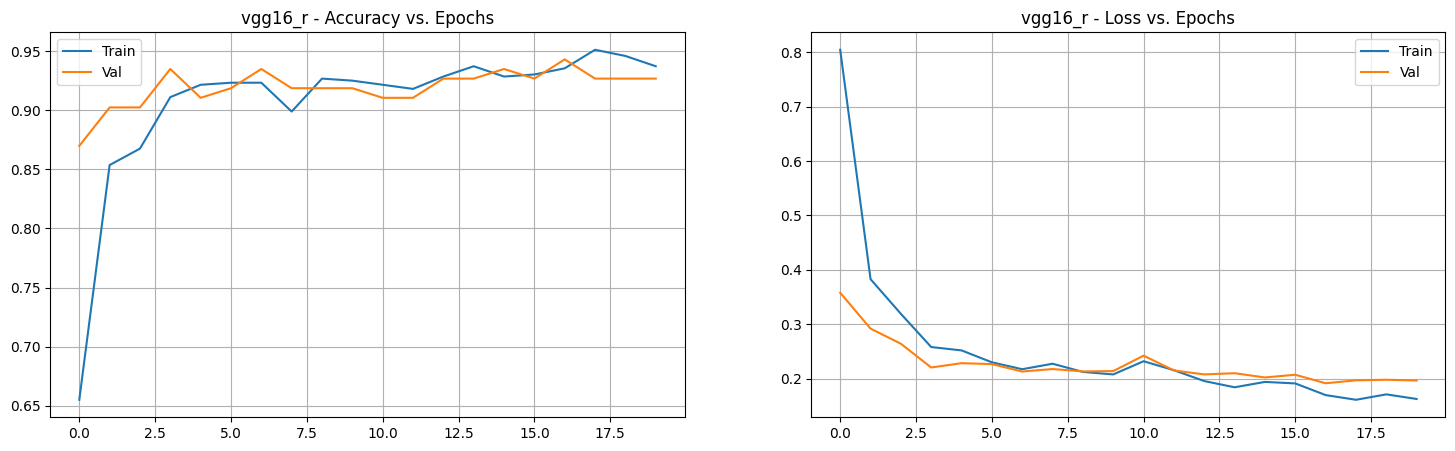


--- Evaluation for vgg16_r ---
              precision    recall  f1-score   support

       Green       1.00      0.93      0.97        30
    Overripe       1.00      0.90      0.95        31
        Ripe       0.84      0.77      0.81        35
   Semi-ripe       0.69      0.89      0.77        27

    accuracy                           0.87       123
   macro avg       0.88      0.87      0.87       123
weighted avg       0.89      0.87      0.87       123



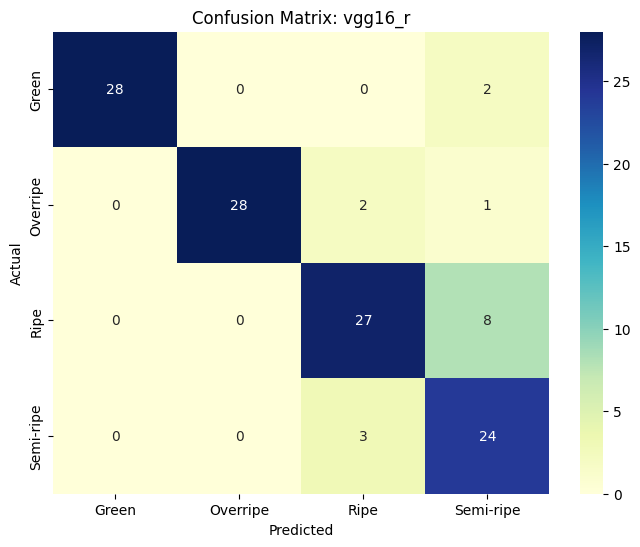



--- FINAL MODEL COMPARISON (BANANA RIPENESS) ---


,Accuracy,F1 Macro
Model,,
BANANA_RIPE_CNN,0.9268,0.9284
resnet50,0.8943,0.8951
mobilenet_v2,0.8780,0.8811
vgg16,0.8699,0.8737
densenet121,0.8618,0.8621
efficientnet_b0,0.8455,0.8485


In [ ]:
models_to_train_r = {
    "BANANA_RIPE_CNN": BANANA_RIPE_CNN(num_classes=NUM_CLASSES_RIPENESS).to(DEVICE),
    "resnet50_r": get_transfer_model("resnet50", num_classes=NUM_CLASSES_RIPENESS),
    "mobilenet_v2_r": get_transfer_model("mobilenet_v2", num_classes=NUM_CLASSES_RIPENESS),
    "efficientnet_b0_r": get_transfer_model("efficientnet_b0", num_classes=NUM_CLASSES_RIPENESS),
    "densenet121_r": get_transfer_model("densenet121", num_classes=NUM_CLASSES_RIPENESS),
    "vgg16_r": get_transfer_model("vgg16", num_classes=NUM_CLASSES_RIPENESS)}

all_results_r = []
for name, model in models_to_train_r.items():
    history = train_model(model, name, train_loader_r, val_loader_r, EPOCHS, LEARNING_RATE, DEVICE)
    plt.figure(figsize=(18, 5)); plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.title(f'{name} - Accuracy vs. Epochs'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.title(f'{name} - Loss vs. Epochs'); plt.legend(); plt.grid(True); plt.show()
    eval_results = evaluate_model(model, name, test_loader_r, class_names_ripeness, DEVICE)
    eval_results['Model'] = name.replace('_r', '')
    all_results_r.append(eval_results)

# --- Final Comparison Table ---
print("\n\n--- FINAL MODEL COMPARISON (BANANA RIPENESS) ---")
results_df_r = pd.DataFrame(all_results_r).set_index('Model').sort_values(by='Accuracy', ascending=False)
display(results_df_r.style.background_gradient(cmap='cividis').format("{:.4f}"))

Ripeness Data Directory: /kaggle/input/bananaimageset/BananaImageBD A Comprehensive Image Dataset of Common Banana Varieties with Different Ripeness Stages in Bangladesh/Banana Ripeness Detection Dataset/Banana Ripeness Detection Dataset
Using device: cuda
Ripeness Classes found (4): ['Green', 'Overripe', 'Ripe', 'Semi-ripe']

Dataset will be split into: Train=574, Validation=123, Test=123

--- Visualizing Ripeness Class Distribution ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


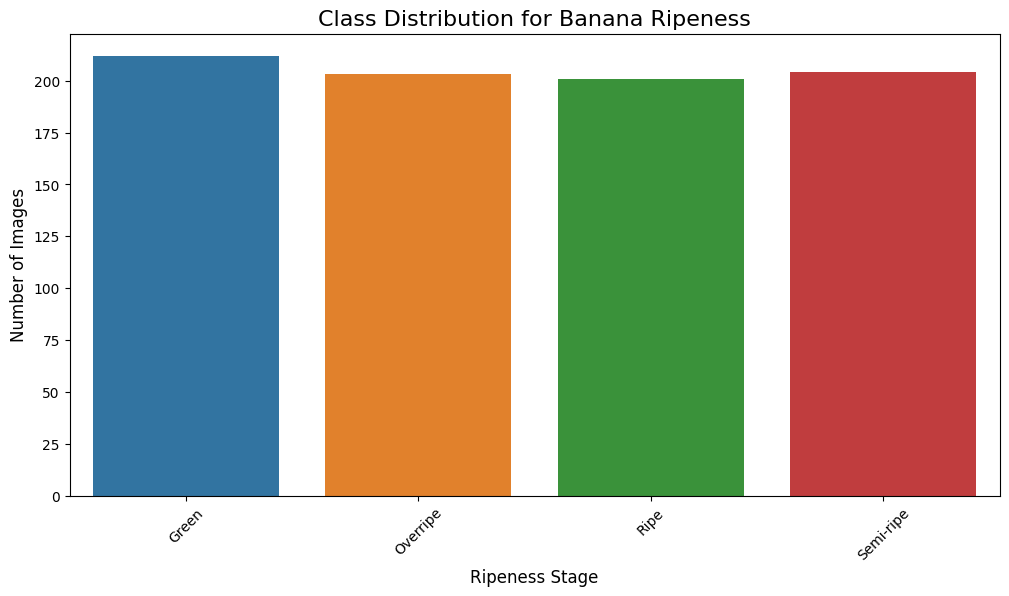


--- Visualizing Sample Ripeness Images ---


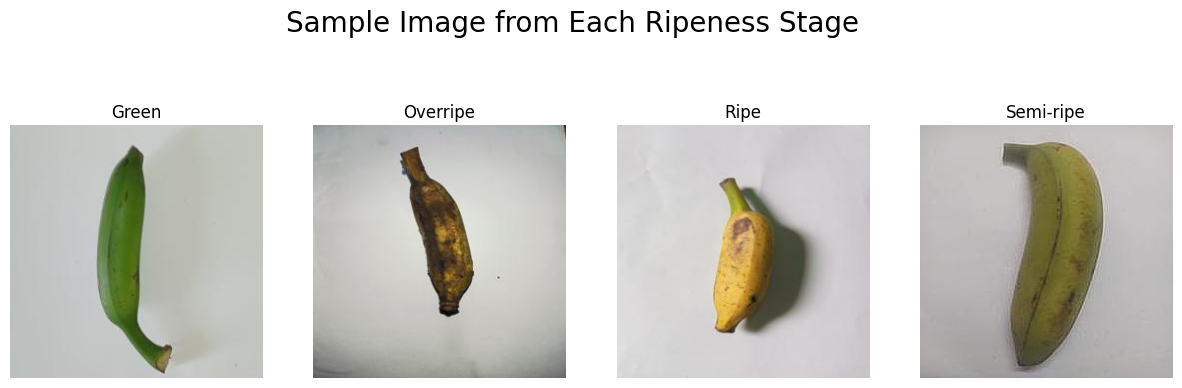



SECTION 2: DEMONSTRATING THE OVERFITTING PROBLEM (RIPENESS)
--- Training Baseline Model (to show overfitting) ---
Epoch 1/15 | Train Acc: 0.3589 | Val Acc: 0.4878
Epoch 2/15 | Train Acc: 0.4704 | Val Acc: 0.5610
Epoch 3/15 | Train Acc: 0.4686 | Val Acc: 0.5447
Epoch 4/15 | Train Acc: 0.4704 | Val Acc: 0.5691
Epoch 5/15 | Train Acc: 0.4756 | Val Acc: 0.5691
Epoch 6/15 | Train Acc: 0.4965 | Val Acc: 0.5691
Epoch 7/15 | Train Acc: 0.5070 | Val Acc: 0.6341
Epoch 8/15 | Train Acc: 0.5662 | Val Acc: 0.7073
Epoch 9/15 | Train Acc: 0.6411 | Val Acc: 0.7154
Epoch 10/15 | Train Acc: 0.6167 | Val Acc: 0.7480
Epoch 11/15 | Train Acc: 0.6707 | Val Acc: 0.7561
Epoch 12/15 | Train Acc: 0.7056 | Val Acc: 0.7805
Epoch 13/15 | Train Acc: 0.7300 | Val Acc: 0.8293
Epoch 14/15 | Train Acc: 0.8014 | Val Acc: 0.8455
Epoch 15/15 | Train Acc: 0.8240 | Val Acc: 0.8618

--- Visualizing the Overfitting Problem (Ripeness) ---


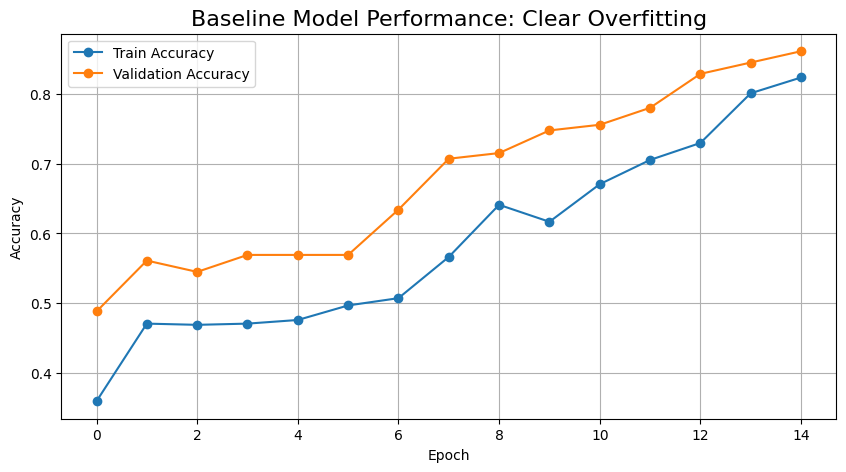

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# --- Path and Hyperparameters (Requirement 6) ---
DATA_DIR_RIPENESS = '/kaggle/input/bananaimageset/BananaImageBD A Comprehensive Image Dataset of Common Banana Varieties with Different Ripeness Stages in Bangladesh/Banana Ripeness Detection Dataset/Banana Ripeness Detection Dataset'
print(f"Ripeness Data Directory: {DATA_DIR_RIPENESS}")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- Load Class Names & Calculate Split Sizes ---
class_names_ripeness = sorted(os.listdir(DATA_DIR_RIPENESS))
NUM_CLASSES_RIPENESS = len(class_names_ripeness)
print(f"Ripeness Classes found ({NUM_CLASSES_RIPENESS}): {class_names_ripeness}")
temp_dataset_r = datasets.ImageFolder(DATA_DIR_RIPENESS)
train_size_r = int(0.7 * len(temp_dataset_r)); val_size_r = int(0.15 * len(temp_dataset_r)); test_size_r = len(temp_dataset_r) - train_size_r - val_size_r
print(f"\nDataset will be split into: Train={train_size_r}, Validation={val_size_r}, Test={test_size_r}")
del temp_dataset_r

# --- Visualization 1: Class Distribution ---
print("\n--- Visualizing Ripeness Class Distribution ---")
class_counts_ripeness = {cls: len(os.listdir(os.path.join(DATA_DIR_RIPENESS, cls))) for cls in class_names_ripeness}
plt.figure(figsize=(12, 6)); sns.barplot(x=list(class_counts_ripeness.keys()), y=list(class_counts_ripeness.values())); plt.title('Class Distribution for Banana Ripeness', fontsize=16); plt.xlabel('Ripeness Stage', fontsize=12); plt.ylabel('Number of Images', fontsize=12); plt.xticks(rotation=45); plt.show()

# --- Visualization 2: Sample Images from Each Category ---
print("\n--- Visualizing Sample Ripeness Images ---")
plt.figure(figsize=(15, 5));
for i, class_name in enumerate(class_names_ripeness):
    ax = plt.subplot(1, NUM_CLASSES_RIPENESS, i + 1)
    img_path = os.path.join(DATA_DIR_RIPENESS, class_name, os.listdir(os.path.join(DATA_DIR_RIPENESS, class_name))[0])
    plt.imshow(Image.open(img_path)); plt.title(class_name); plt.axis("off")
plt.suptitle('Sample Image from Each Ripeness Stage', fontsize=20); plt.show()

# --- Define ALL Transformations ---
no_aug_transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_transforms = transforms.Compose([transforms.TrivialAugmentWide(), transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_test_transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# ==============================================================================
# SECTION 2: THE OVERFITTING PROBLEM: A BASELINE MODEL (Requirement 6)
# ==============================================================================
print("\n\n" + "="*60 + "\nSECTION 2: DEMONSTRATING THE OVERFITTING PROBLEM (RIPENESS)\n" + "="*60)
class BANANA_RIPE_CNN_Simple(nn.Module):
    def __init__(self, num_classes):
        super(BANANA_RIPE_CNN_Simple, self).__init__(); self.features = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)); self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(32, num_classes), nn.Softmax(dim=1))
    def forward(self, x): return self.classifier(self.features(x))

full_dataset_noaug_r = datasets.ImageFolder(DATA_DIR_RIPENESS, transform=no_aug_transforms)
train_ds_noaug_r, val_ds_noaug_r, _ = random_split(full_dataset_noaug_r, [train_size_r, val_size_r, test_size_r])
train_loader_noaug_r = DataLoader(train_ds_noaug_r, batch_size=BATCH_SIZE, shuffle=True)
val_loader_noaug_r = DataLoader(val_ds_noaug_r, batch_size=BATCH_SIZE, shuffle=False)

def train_baseline(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_acc': [], 'val_acc': []}
    print("--- Training Baseline Model (to show overfitting) ---")
    for epoch in range(epochs):
        model.train(); train_correct, train_total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device); optimizer.zero_grad(); outputs = model(inputs)
            loss = criterion(outputs, labels); loss.backward(); optimizer.step()
            _, predicted = torch.max(outputs.data, 1); train_total += labels.size(0); train_correct += (predicted == labels).sum().item()
        model.eval(); val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device)); labels = labels.to(device)
                _, predicted = torch.max(outputs.data, 1); val_total += labels.size(0); val_correct += (predicted == labels).sum().item()
        train_acc, val_acc = train_correct/train_total, val_correct/val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
    return history

baseline_model_r = BANANA_RIPE_CNN_Simple(num_classes=NUM_CLASSES_RIPENESS).to(DEVICE)
baseline_history_r = train_baseline(baseline_model_r, train_loader_noaug_r, val_loader_noaug_r, epochs=15, lr=0.001, device=DEVICE)

print("\n--- Visualizing the Overfitting Problem (Ripeness) ---")
plt.figure(figsize=(10, 5)); plt.plot(baseline_history_r['train_acc'], label='Train Accuracy', marker='o'); plt.plot(baseline_history_r['val_acc'], label='Validation Accuracy', marker='o'); plt.title('Baseline Model Performance: Clear Overfitting', fontsize=16); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.show()

